In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# ---------------------------------------
# Sampling Triangle
# ---------------------------------------
def sample_triangle(n):
    u = np.random.rand(n)
    v = np.random.rand(n)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return np.column_stack([u, v])

# ---------------------------------------
# Graph Laplacian with matching kernel
# ---------------------------------------
def compute_graph_laplacian(X, f_vals, t):
    n = X.shape[0]
    d = X.shape[1]
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    L_f = np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)
    return L_f

# ---------------------------------------
# Main Evaluation
# ---------------------------------------
n = 10000
np.random.seed(0)
X_base = sample_triangle(n)
X = np.vstack([
    np.array([[0.0, 0.0]]),     # tip
    np.array([[0.5, 0.0]]),     # edge
    X_base
])
f_vals = X[:, 0] + X[:, 1]  # f(x, y) = x + y

# Test multiple t values
t_values = [0.1, 0.05, 0.01, 0.005, 0.001]
L_tip_vals = []
L_edge_vals = []
sqrt_t_L_tip_vals = []
sqrt_t_L_edge_vals = []

for t in t_values:
    L_f = compute_graph_laplacian(X, f_vals, t)
    L_tip = L_f[0]
    L_edge = L_f[1]
    L_tip_vals.append(L_tip)
    L_edge_vals.append(L_edge)
    sqrt_t_L_tip_vals.append(np.sqrt(t) * L_tip)
    sqrt_t_L_edge_vals.append(np.sqrt(t) * L_edge)

# ---------------------------------------
# Final Table Output
# ---------------------------------------
print("\n--- Blow-Up Analysis Table ---")
print(f"{'t':>8} | {'L_tip':>10} | {'L_edge':>10} | {'√t·L_tip':>10} | {'√t·L_edge':>10}")
print("-" * 58)
for i in range(len(t_values)):
    print(f"{t_values[i]:8.4f} | {L_tip_vals[i]:10.5f} | {L_edge_vals[i]:10.5f} | "
          f"{sqrt_t_L_tip_vals[i]:10.5f} | {sqrt_t_L_edge_vals[i]:10.5f}")



--- Blow-Up Analysis Table ---
       t |      L_tip |     L_edge |   √t·L_tip |  √t·L_edge
----------------------------------------------------------
  0.1000 |    1.78124 |    1.12790 |    0.56328 |    0.35667
  0.0500 |    2.56078 |    2.26101 |    0.57261 |    0.50558
  0.0100 |    6.00122 |    6.15311 |    0.60012 |    0.61531
  0.0050 |    8.63811 |    8.53835 |    0.61081 |    0.60375
  0.0010 |   16.20387 |   18.60389 |    0.51241 |    0.58831


In [2]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import KernelDensity

# ========================================================
# 1. Uniform sampling inside triangle using reflection
# ========================================================

def uniform_sample_triangle(A, B, C, n_samples):
    """
    Generates `n_samples` uniformly distributed points within triangle ABC.

    Parameters:
        A, B, C: Tuples or arrays representing triangle vertices (x, y)
        n_samples: Number of points to generate

    Returns:
        numpy.ndarray: Array of shape (n_samples, 2)
    """
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)

    # Reflect (u, v) across the line u + v = 1 to keep points within triangle
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]

    samples = (1 - u - v)[:, None] * np.array(A) + u[:, None] * np.array(B) + v[:, None] * np.array(C)
    return samples


# ========================================================
# 2. Compute Graph Laplacian with normalized heat kernel
# ========================================================

def compute_graph_laplacian(X, f_vals, t):
    """
    Computes the unnormalized graph Laplacian L_t f(x) at each point x in X,
    using a normalized Gaussian kernel (heat kernel).
    """
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)


# ========================================================
# 3. KDE Uniformity Test
# ========================================================

def kde_uniformity_test(X_sampled, area=(np.sqrt(3)/4), bandwidth=0.1):
    """
    Tests if the samples in X are uniformly distributed over a triangle
    by evaluating the kernel density at 20 new random points.
    """
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_sampled)

    # Triangle vertices
    A = (0.0, 0.0)
    B = (1.0, 0.0)
    C = (0.5, np.sqrt(3)/2)

    check_points = uniform_sample_triangle(A, B, C, 20)
    log_dens = kde.score_samples(check_points)
    estimated_dens = np.exp(log_dens)
    expected_density = 1 / area
    errors = estimated_dens - expected_density

    # Print results
    print("\n--- KDE Uniformity Test ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, est, err in zip(check_points, estimated_dens, errors):
        print(f"{str(np.round(pt, 3)):>20} | {est:10.4f} | {err:10.4f}")


# ========================================================
# 4. Laplacian Evaluation
# ========================================================

def evaluate_laplacian_for_function(f, label):
    """
    Evaluates the graph Laplacian L_t f(x) and its scaled version sqrt(t)·L_t f(x)
    at 6 fixed reference points for a given function f.
    """
    n = 10000
    np.random.seed(0)

    A = (0.0, 0.0)
    B = (1.0, 0.0)
    C = (0.5, np.sqrt(3)/2)
    X_base = uniform_sample_triangle(A, B, C, n_samples=n)

    h = np.sqrt(3) / 2
    fixed_points = np.array([
        [0.0, 0.0],        # A
        [1.0, 0.0],        # B
        [0.5, h],          # C
        [0.5, 0.0],        # Mid AB
        [0.75, h / 2],     # Mid BC
        [0.25, h / 2],     # Mid CA
    ])

    X = np.vstack([fixed_points, X_base])
    f_vals = f(X[:, 0], X[:, 1])

    t_values = [0.1, 0.05, 0.01, 0.005, 0.001]
    raw_L = []
    scaled_L = []

    for t in t_values:
        L_f = compute_graph_laplacian(X, f_vals, t)
        raw_L.append(L_f[:6])
        scaled_L.append(np.sqrt(t) * L_f[:6])

    print(f"\n--- Raw L_t f(x) for {label} ---")
    print("t       | " + " | ".join([f"L{i}" for i in range(6)]))
    print("-" * 70)
    for i, t in enumerate(t_values):
        print(f"{t:<7.4f} | " + " | ".join(f"{v:8.4f}" for v in raw_L[i]))

    print(f"\n--- Scaled √t·L_t f(x) for {label} ---")
    print("t       | " + " | ".join([f"S{i}" for i in range(6)]))
    print("-" * 70)
    for i, t in enumerate(t_values):
        print(f"{t:<7.4f} | " + " | ".join(f"{v:8.4f}" for v in scaled_L[i]))


# ========================================================
# 5. Run Tests
# ========================================================

# Triangle vertices
A = (0.0, 0.0)
B = (1.0, 0.0)
C = (0.5, np.sqrt(3)/2)

# Test KDE for uniformity
X_sampled = uniform_sample_triangle(A, B, C, n_samples=10000)
kde_uniformity_test(X_sampled, area=(np.sqrt(3)/4), bandwidth=0.1)

# Evaluate Laplacian for two functions
evaluate_laplacian_for_function(lambda x, y: x + y, "f(x) = x1 + x2")
evaluate_laplacian_for_function(lambda x, y: x, "f(x) = x1")



--- KDE Uniformity Test ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.069 0.086] |     0.9763 |    -1.3331
       [0.563 0.491] |     2.0431 |    -0.2663
       [0.828 0.247] |     1.3503 |    -0.9591
         [0.86 0.05] |     1.2662 |    -1.0432
       [0.505 0.353] |     2.3040 |    -0.0054
       [0.261 0.031] |     1.4409 |    -0.8685
       [0.596 0.114] |     2.0746 |    -0.2348
       [0.192 0.276] |     1.3773 |    -0.9321
       [0.439 0.014] |     1.3128 |    -0.9966
       [0.495 0.418] |     2.2578 |    -0.0516
       [0.947 0.046] |     0.7844 |    -1.5250
       [0.18  0.254] |     1.3872 |    -0.9222
       [0.241 0.146] |     1.9678 |    -0.3416
       [0.426 0.672] |     1.2879 |    -1.0215
       [0.776 0.342] |     1.3411 |    -0.9683
       [0.429 0.481] |     2.0575 |    -0.2519
       [0.531 0.538] |     1.9904 |    -0.3190
       [0.695 0.059] |     1.6848 |    -0.6246
       [0.508 0.39 ] |     

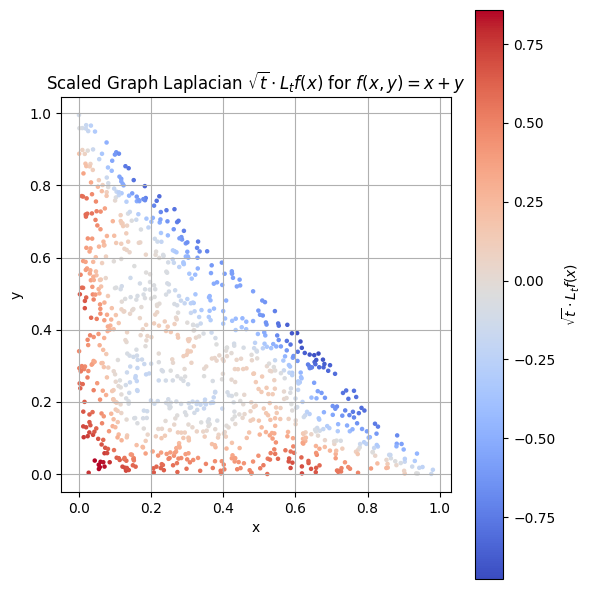

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Sample uniformly inside the triangle ---
def sample_triangle(n):
    u = np.random.rand(n)
    v = np.random.rand(n)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return np.column_stack([u, v])

# --- Compute graph Laplacian using normalized heat kernel ---
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# --- Generate data and compute scaled Laplacian ---
np.random.seed(0)
X = sample_triangle(1000)
f_vals = X[:, 0] + X[:, 1]  # f(x, y) = x + y
t = 0.01
L_vals = compute_graph_laplacian(X, f_vals, t)
scaled_L_vals = np.sqrt(t) * L_vals  # <--- SCALE by √t

# --- Visualize the scaled Laplacian values ---
plt.figure(figsize=(6, 6))
sc = plt.scatter(X[:, 0], X[:, 1], c=scaled_L_vals, cmap='coolwarm', s=5)
plt.colorbar(sc, label=r"$\sqrt{t} \cdot L_t f(x)$")
plt.title(r"Scaled Graph Laplacian $\sqrt{t} \cdot L_t f(x)$ for $f(x, y) = x + y$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


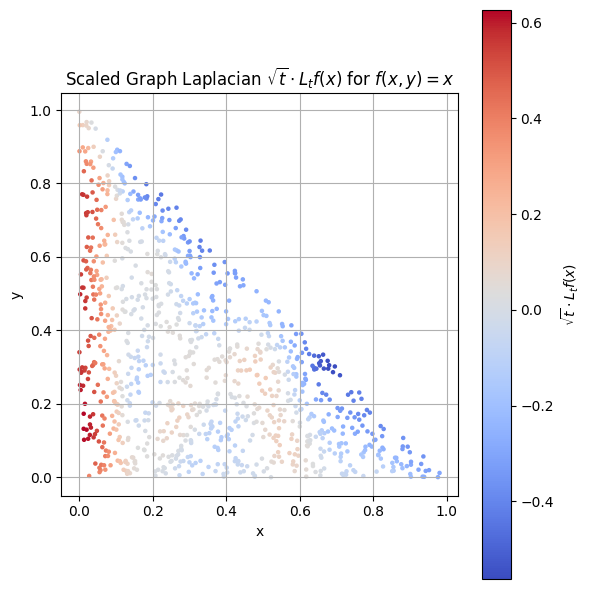

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Sample uniformly inside the triangle ---
def sample_triangle(n):
    u = np.random.rand(n)
    v = np.random.rand(n)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return np.column_stack([u, v])

# --- Compute graph Laplacian using normalized heat kernel ---
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# --- Generate data and compute scaled Laplacian ---
np.random.seed(0)
X = sample_triangle(1000)
f_vals = X[:, 0]  # f(x, y) = x only
t = 0.01
L_vals = compute_graph_laplacian(X, f_vals, t)
scaled_L_vals = np.sqrt(t) * L_vals

# --- Visualize the scaled Laplacian values ---
plt.figure(figsize=(6, 6))
sc = plt.scatter(X[:, 0], X[:, 1], c=scaled_L_vals, cmap='coolwarm', s=5)
plt.colorbar(sc, label=r"$\sqrt{t} \cdot L_t f(x)$")
plt.title(r"Scaled Graph Laplacian $\sqrt{t} \cdot L_t f(x)$ for $f(x, y) = x$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import KernelDensity

# ========================================================
# 1. Sample uniformly inside a square-based pyramid
# ========================================================
def sample_pyramid(n):
    def sample_tetrahedron_pts(a, b, c, d, m):
        u = np.random.rand(m, 3)
        u.sort(axis=1)
        a_w = 1.0 - u[:, 2]
        b_w = u[:, 2] - u[:, 1]
        c_w = u[:, 1] - u[:, 0]
        d_w = u[:, 0]
        return (a_w[:, None] * a +
                b_w[:, None] * b +
                c_w[:, None] * c +
                d_w[:, None] * d)
    
    A = np.array([0, 0, 0])
    B = np.array([1, 0, 0])
    C = np.array([1, 1, 0])
    D = np.array([0, 1, 0])
    E = np.array([0.5, 0.5, 1])

    n1 = n // 2
    n2 = n - n1
    pts1 = sample_tetrahedron_pts(A, B, E, D, n1)
    pts2 = sample_tetrahedron_pts(B, C, E, D, n2)
    
    return np.vstack([pts1, pts2])

# ========================================================
# 2. Compute Graph Laplacian with normalized heat kernel
# ========================================================
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# ========================================================
# 3. KDE test for pyramid sampling
# ========================================================
def kde_uniformity_test_pyramid(X, volume=1/3, bandwidth=0.05):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)

    np.random.seed(42)
    check_points = sample_pyramid(20)
    log_dens = kde.score_samples(check_points)
    estimated_dens = np.exp(log_dens)
    expected_density = 1 / volume
    errors = estimated_dens - expected_density

    print("\n--- KDE Uniformity Test (Pyramid) ---")
    print(f"{'Point':>30} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 60)
    for pt, est, err in zip(check_points, estimated_dens, errors):
        print(f"{str(np.round(pt, 3)):>30} | {est:10.4f} | {err:10.4f}")

# ========================================================
# 4. Evaluate Laplacian for a function inside pyramid
# ========================================================
def evaluate_laplacian_for_function_pyramid(f, label):
    n = 10000
    np.random.seed(0)
    X_base = sample_pyramid(n)

    fixed_points = np.array([
        [0.0, 0.0, 0.0],   # Base corner A
        [1.0, 0.0, 0.0],   # Base corner B
        [1.0, 1.0, 0.0],   # Base corner C
        [0.0, 1.0, 0.0],   # Base corner D
        [0.5, 0.5, 1.0],   # Apex E
        [0.5, 0.5, 0.0],   # Center of base
    ])
    X = np.vstack([fixed_points, X_base])
    f_vals = f(X[:, 0], X[:, 1], X[:, 2])

    t_values = [0.1, 0.05, 0.01, 0.005, 0.001]
    raw_L = []
    scaled_L = []

    for t in t_values:
        L_f = compute_graph_laplacian(X, f_vals, t)
        raw_L.append(L_f[:6])
        scaled_L.append(np.sqrt(t) * L_f[:6])

    print(f"\n--- Raw L_t f(x) for {label} ---")
    print("t       | " + " | ".join([f"L{i}" for i in range(6)]))
    print("-" * 90)
    for i, t in enumerate(t_values):
        print(f"{t:<7.4f} | " + " | ".join(f"{v:10.6f}" for v in raw_L[i]))

    print(f"\n--- Scaled √t·L_t f(x) for {label} ---")
    print("t       | " + " | ".join([f"S{i}" for i in range(6)]))
    print("-" * 90)
    for i, t in enumerate(t_values):
        print(f"{t:<7.4f} | " + " | ".join(f"{v:10.6f}" for v in scaled_L[i]))

# ========================================================
# 5. Run Tests: KDE and Laplacian for 2 functions
# ========================================================
X_sampled = sample_pyramid(100000)
kde_uniformity_test_pyramid(X_sampled, volume=1/3)

evaluate_laplacian_for_function_pyramid(lambda x, y, z: x + y + z, "f(x, y, z) = x + y + z")
evaluate_laplacian_for_function_pyramid(lambda x, y, z: x**2 - y**2 + z, "f(x, y, z) = x² - y² + z")



--- KDE Uniformity Test (Pyramid) ---
                         Point |  Estimated |      Error
------------------------------------------------------------
           [0.397 0.553 0.357] |     3.0368 |     0.0368
           [0.443 0.156 0.   ] |     1.5357 |    -1.4643
           [0.537 0.33  0.543] |     2.4628 |    -0.5372
           [0.606 0.364 0.687] |     1.6475 |    -1.3525
           [0.635 0.197 0.031] |     2.1465 |    -0.8535
           [0.281 0.244 0.121] |     2.9109 |    -0.0891
           [0.25  0.362 0.141] |     2.8650 |    -0.1350
           [0.151 0.216 0.153] |     2.7030 |    -0.2970
           [0.457 0.328 0.256] |     2.9707 |    -0.0293
           [0.312 0.28  0.468] |     2.3149 |    -0.6851
           [0.882 0.555 0.105] |     2.6180 |    -0.3820
           [0.121 0.895 0.14 ] |     1.8187 |    -1.1813
           [0.799 0.581 0.207] |     3.0015 |     0.0015
           [0.719 0.336 0.318] |     2.9025 |    -0.0975
           [0.853 0.797 0.224] |     2.0456 |

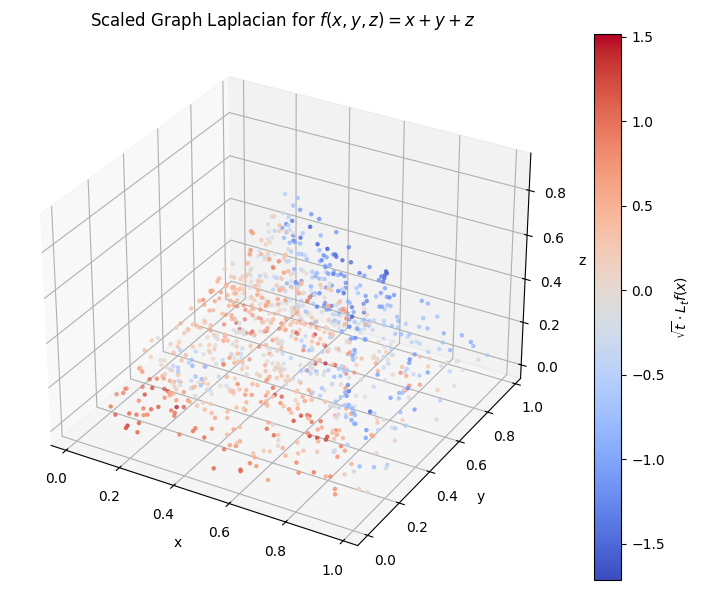

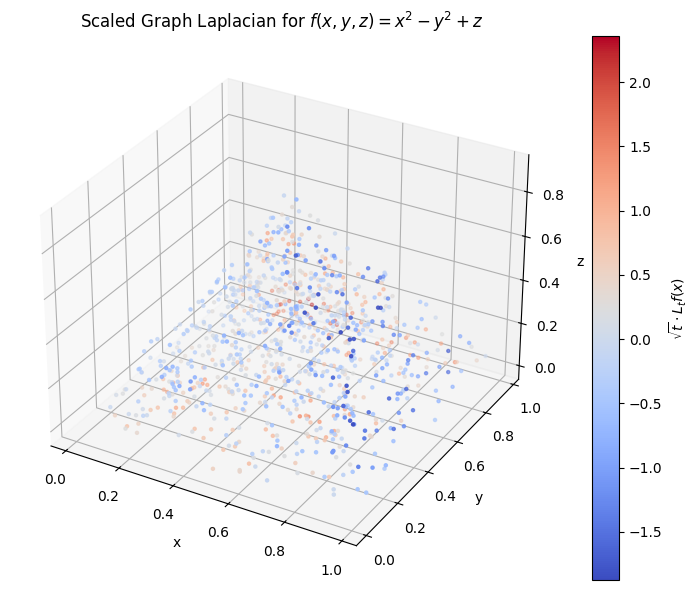

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Sample uniformly inside a square-based pyramid ---
def sample_pyramid(n):
    def sample_tetrahedron_pts(a, b, c, d, m):
        u = np.random.rand(m, 3)
        u.sort(axis=1)
        a_w = 1.0 - u[:, 2]
        b_w = u[:, 2] - u[:, 1]
        c_w = u[:, 1] - u[:, 0]
        d_w = u[:, 0]
        return (a_w[:, None] * a +
                b_w[:, None] * b +
                c_w[:, None] * c +
                d_w[:, None] * d)

    A = np.array([0, 0, 0])
    B = np.array([1, 0, 0])
    C = np.array([1, 1, 0])
    D = np.array([0, 1, 0])
    E = np.array([0.5, 0.5, 1])
    n1 = n // 2
    n2 = n - n1
    pts1 = sample_tetrahedron_pts(A, B, E, D, n1)
    pts2 = sample_tetrahedron_pts(B, C, E, D, n2)
    return np.vstack([pts1, pts2])

# --- Compute graph Laplacian using normalized heat kernel ---
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# --- Function to compute and plot scaled Laplacian for a given f ---
def visualize_scaled_laplacian(f, label, t=0.01):
    np.random.seed(0)
    X = sample_pyramid(1000)
    f_vals = f(X[:, 0], X[:, 1], X[:, 2])
    L_vals = compute_graph_laplacian(X, f_vals, t)
    scaled_L_vals = np.sqrt(t) * L_vals

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=scaled_L_vals, cmap='coolwarm', s=5)
    plt.colorbar(sc, ax=ax, label=r"$\sqrt{t} \cdot L_t f(x)$")
    ax.set_title(f"Scaled Graph Laplacian for {label}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.tight_layout()
    plt.show()

# --- Run for both functions ---
visualize_scaled_laplacian(lambda x, y, z: x + y + z, r"$f(x, y, z) = x + y + z$")
visualize_scaled_laplacian(lambda x, y, z: x**2 - y**2 + z, r"$f(x, y, z) = x^2 - y^2 + z$")
